# Import data as 'df'

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('./london_weather.csv')
df.drop(columns = ['snow_depth'], inplace = True)
df.dropna(inplace= True)
df.reset_index(drop=True, inplace=True)

#get mean monthly temp
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df=df.groupby('month_year').mean()
df=df['mean_temp']
df=df.to_frame() #transfer 'df' from Series to DataFrame


df




C:\Users\CJyM2\AppData\Local\Temp\ipykernel_36124\173685841.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df=df.groupby('month_year').mean()


,mean_temp
month_year,
1979-01,0.527586
1979-02,2.028000
1979-03,5.587097
1979-04,8.743333
1979-05,11.490323
...,...
2020-08,20.393333
2020-09,16.616667
2020-10,11.933333


# Find the optimal model by auto_arima

In [2]:
# Split data into train / test sets as the ratio of 8:2
n=int(len(df)*0.2)
train = df.iloc[:len(df)-n]
test = df.iloc[len(df)-n:]

In [4]:
# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(df['mean_temp'], # input 'mean_temp' as the dominant variable 
                          m = 12, # set the period to be one month
                          seasonal = True, # turn on the seasonality check
                          trace = True, # report considered ARIMA model
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# Print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3073.607, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2459.229, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3979.973, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2672.683, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1855.231, Time=1.56 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2091.886, Time=0.92 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2337.993, Time=0.91 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2037.249, Time=3.20 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1881.096, Time=1.25 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  504
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -918.876
Date:                              Wed, 05 Apr 2023   AIC                           1851.751
Time:                                      22:35:49   BIC                           1881.309
Sample:                                           0   HQIC                          1863.346
                                              - 504                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0271      0.017      1.607      0.108      -0.006       0.060
ar.L1         -0.9871      0.363     -2.723      0.006      -1.698      -0.277
ma.L1          1.1961      0.364      3.285      0.001       0.483       1.910
ma.L2          0.2069      0.081      2.559      0.011       0.048       0.365
ar.S.L12       0.9988      0.001   1329.517      0.000       0.997       1.000
ma.S.L12      -0.8702      0.031    -28.334      0.000      -0.930      -0.810
sigma2         2.0647      0.124     16.711      0.000       1.823       2.307
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.91   Prob(JB):                         0.09
Heteroskedasticity (H):               0.76   Skew:                            -0.09
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Build up ARIMA with optimal parameters selected by auto_arima

In [4]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# build up (1,0,1)(2,1,0,12) ARIMA Model
model = ARIMA(train['mean_temp'], 
                #order = (12, 0, 4), 
                seasonal_order =(12, 0, 4, 12))


result = model.fit()#Fit (estimate) the parameters of the model.
result.summary()

C:\Users\CJyM2\Documents\anaconda\envs\ARIMA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\CJyM2\Documents\anaconda\envs\ARIMA\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          mean_temp   No. Observations:                  404
Model:             ARIMA(12, 0, [1, 2, 3, 4], 12)   Log Likelihood                -740.755
Date:                            Wed, 05 Apr 2023   AIC                           1517.510
Time:                                    23:50:09   BIC                           1589.536
Sample:                                01-31-1979   HQIC                          1546.022
                                     - 08-31-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0027      1.617      6.805      0.000       7.834      14.172
ar.S.L12       0.2561      0.314      0.815      0.415      -0.360       0.872
ar.S.L24       1.0604      0.280      3.781      0.000       0.511       1.610
ar.S.L36       0.0179      0.272      0.066      0.947      -0.515       0.551
ar.S.L48      -0.8177      0.252     -3.250      0.001      -1.311      -0.325
ar.S.L60       0.2821      0.107      2.636      0.008       0.072       0.492
ar.S.L72       0.1593      0.111      1.439      0.150      -0.058       0.376
ar.S.L84      -0.0920      0.114     -0.804      0.422      -0.316       0.132
ar.S.L96      -0.0079      0.114     -0.069      0.945      -0.232       0.216
ar.S.L108      0.1374      0.101      1.362      0.173      -0.060       0.335
ar.S.L120      0.0255      0.104      0.244      0.807      -0.179       0.230
ar.S.L132     -0.0801      0.098     -0.819      0.413      -0.272       0.112
ar.S.L144      0.0552      0.113      0.489      0.625      -0.166       0.277
ma.S.L12      -0.0708      0.322     -0.220      0.826      -0.702       0.560
ma.S.L24      -1.0095      0.279     -3.616      0.000      -1.557      -0.462
ma.S.L36      -0.1626      0.261     -0.623      0.534      -0.675       0.349
ma.S.L48       0.6983      0.240      2.910      0.004       0.228       1.169
sigma2         1.9956      0.154     12.956      0.000       1.694       2.298
===================================================================================
Ljung-Box (L1) (Q):                   9.47   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.00   Prob(JB):                         0.36
Heteroskedasticity (H):               0.81   Skew:                            -0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predicting from the end of the training set until 60 months after the entire set 'df'

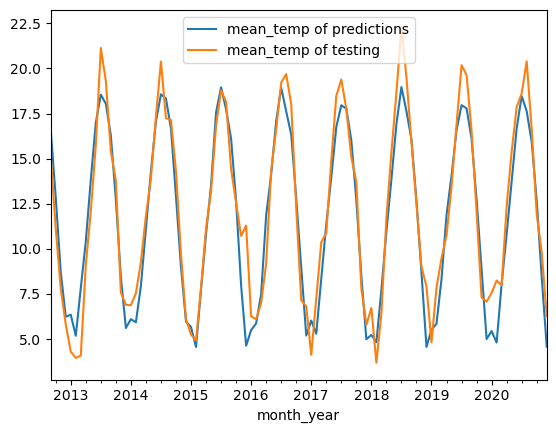

In [5]:
#Predictions of ARIMA Model against the test set
start = len(train)
end = len(df)+60 # next 60 months

# Predictions for one-year against the test set
predictions = result.predict(start, end, dynamic=True)#dynamic = True means new predicted values will be attached to the end of original datasets for further steps

# plot predictions and actual values on the same axis
predictions.iloc[:len(test)].plot(legend = True)
test['mean_temp'].plot(legend = True)

plt.legend(["mean_temp of predictions", "mean_temp of testing"])

plt.show()


In [6]:
predictions

2012-09    16.597134
2012-10    12.859672
2012-11     8.710594
2012-12     6.233098
2013-01     6.349313
             ...    
2025-09    16.052134
2025-10    12.743430
2025-11     8.623158
2025-12     5.028114
2026-01     5.665655
Freq: M, Name: predicted_mean, Length: 161, dtype: float64

In [7]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
RMSE=rmse(test["mean_temp"], predictions.iloc[:len(test)])
  
# Calculate mean squared error
ERROR=mean_squared_error(test["mean_temp"], predictions.iloc[:len(test)])

In [8]:
ERROR

2.525514504545594

In [10]:
RMSE

1.589186743131717

# Forecasting 5 years

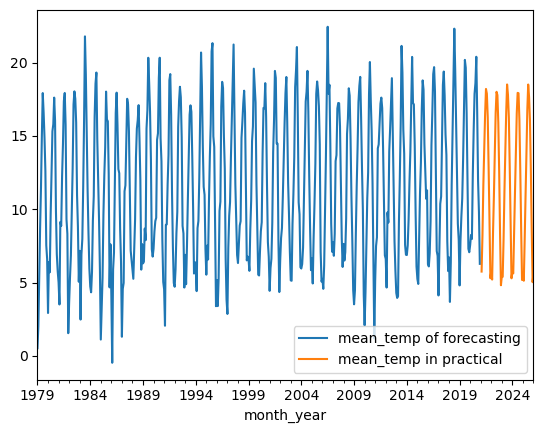

In [11]:
df['mean_temp'].plot(legend = True)
predictions.iloc[-60:].plot(legend = True)

plt.legend(["mean_temp of forecasting", "mean_temp in practical"])
plt.show()